In [1]:
import tensorflow as tf

# List available GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            # Set memory growth to True to allocate memory as needed
            tf.config.experimental.set_memory_growth(gpu, True)
            # Set a memory limit of 10GB (10240MB)
            tf.config.experimental.set_virtual_device_configuration(
                gpu,
                [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=11264)])
    except RuntimeError as e:
        print(e)


In [2]:
# Print TensorFlow version
print("TensorFlow version:", tf.__version__)

# List all physical devices
gpus = tf.config.list_physical_devices('GPU')
print("GPUs available:", gpus)

# Check if TensorFlow is using the GPU
if gpus:
    print("Number of GPUs available: ", len(gpus))
    for gpu in gpus:
        print("GPU:", gpu)

    # Perform a simple computation on the GPU
    with tf.device('/GPU:0'):
        a = tf.constant(2.0)
        b = tf.constant(3.0)
        c = a * b
        print(f"Result of computation on GPU: {c.numpy()}")
else:
    print("No GPU found")


TensorFlow version: 2.10.0
GPUs available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Number of GPUs available:  1
GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Result of computation on GPU: 6.0


# Get the required data

In [3]:
train_dir = "D:\\Wikiart_splitted\\train"
test_dir = "D:\\Wikiart_splitted\\test"
val_dir= "D:\\Wikiart_splitted\\val"

# Import necessary libraries and modules

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping


In [5]:
# Set random seed for reproducibility
random_seed = 42
np.random.seed(random_seed)

# Prepare the data

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 32
img_height = 299  # Adjusted for Xception
img_width = 299

# Training data generator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Validation and test data generator
test_val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=random_seed
)

val_generator = test_val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Ensure consistent order
)

test_generator = test_val_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Ensure consistent order
)

# Define number of classes
num_classes = train_generator.num_classes


Found 60768 images belonging to 19 classes.
Found 7596 images belonging to 19 classes.
Found 7596 images belonging to 19 classes.


# Model building and training

In [14]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Reshape, Concatenate, GlobalAveragePooling2D, BatchNormalization, Activation
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# Set batch size
batch_size = 32

# Check if the class indices match between train and validation generators
num_classes = train_generator.num_classes
assert num_classes == val_generator.num_classes

# Adjusted input size to be divisible by patch size
adjusted_input_size = 300  # Adjusted to be easily divisible by patch size
patch_size = (75, 75)  # Define the size of each patch
num_patches = (adjusted_input_size // patch_size[0], adjusted_input_size // patch_size[1])

def build_patched_cnn_model(input_shape, patch_size, num_patches):
    inputs = Input(shape=input_shape)
    
    # Resize input to adjusted size
    resized_inputs = tf.image.resize(inputs, [adjusted_input_size, adjusted_input_size])
    
    # Reshape the input into patches
    patch_height, patch_width = patch_size
    patches = Reshape((num_patches[0], patch_height, num_patches[1], patch_width, 3))(resized_inputs)
    patches = Reshape((-1, patch_height, patch_width, 3))(patches)  # Flatten the grid of patches
    
    # Process each patch individually using a small CNN
    def process_patch(patch):
        x = Conv2D(32, (3, 3), activation='relu')(patch)
        x = MaxPooling2D((2, 2))(x)
        x = Conv2D(64, (3, 3), activation='relu')(x)
        x = MaxPooling2D((2, 2))(x)
        x = Flatten()(x)
        return x
    
    patch_outputs = [process_patch(patches[:, i]) for i in range(num_patches[0] * num_patches[1])]
    
    # Concatenate the processed patches
    x = Concatenate()(patch_outputs)
    
    # Apply fully connected layers on the concatenated patch outputs
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    
    # Output layer for classification
    output = Dense(num_classes, activation='softmax')(x)  # Ensure the number of classes matches
    
    model = Model(inputs=inputs, outputs=output)
    
    return model

cnn_model = build_patched_cnn_model(input_shape=(adjusted_input_size, adjusted_input_size, 3), patch_size=patch_size, num_patches=num_patches)
cnn_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint('patched_model.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)

# Train the CNN model
history = cnn_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    epochs=10,
    callbacks=[checkpoint, early_stopping]
)


Epoch 1/10
1899/1899 [==============================] - ETA: 0s - loss: 2.6003 - accuracy: 0.1800
Epoch 1: val_accuracy improved from -inf to 0.24407, saving model to patched_model.h5
1899/1899 [==============================] - 1400s 736ms/step - loss: 2.6003 - accuracy: 0.1800 - val_loss: 2.4360 - val_accuracy: 0.2441
Epoch 2/10
1899/1899 [==============================] - ETA: 0s - loss: 2.4296 - accuracy: 0.2252
Epoch 2: val_accuracy improved from 0.24407 to 0.25646, saving model to patched_model.h5
1899/1899 [==============================] - 1395s 735ms/step - loss: 2.4296 - accuracy: 0.2252 - val_loss: 2.3393 - val_accuracy: 0.2565
Epoch 3/10
1899/1899 [==============================] - ETA: 0s - loss: 2.3480 - accuracy: 0.2423
Epoch 3: val_accuracy improved from 0.25646 to 0.27940, saving model to patched_model.h5
1899/1899 [==============================] - 1417s 746ms/step - loss: 2.3480 - accuracy: 0.2423 - val_loss: 2.2271 - val_accuracy: 0.2794
Epoch 4/10
1899/1899 [======

In [20]:
cnn_model.save('patches_cnn.h5')

# Evaluate the model 

In [21]:
cnn_model.load_weights('patched_model.h5')
loss, accuracy = cnn_model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print(f'Test accuracy: {accuracy}')


237/237 [==============================] - 76s 322ms/step - loss: 2.0717 - accuracy: 0.3220
Test accuracy: 0.3219936788082123


# Generate training and validation graphs

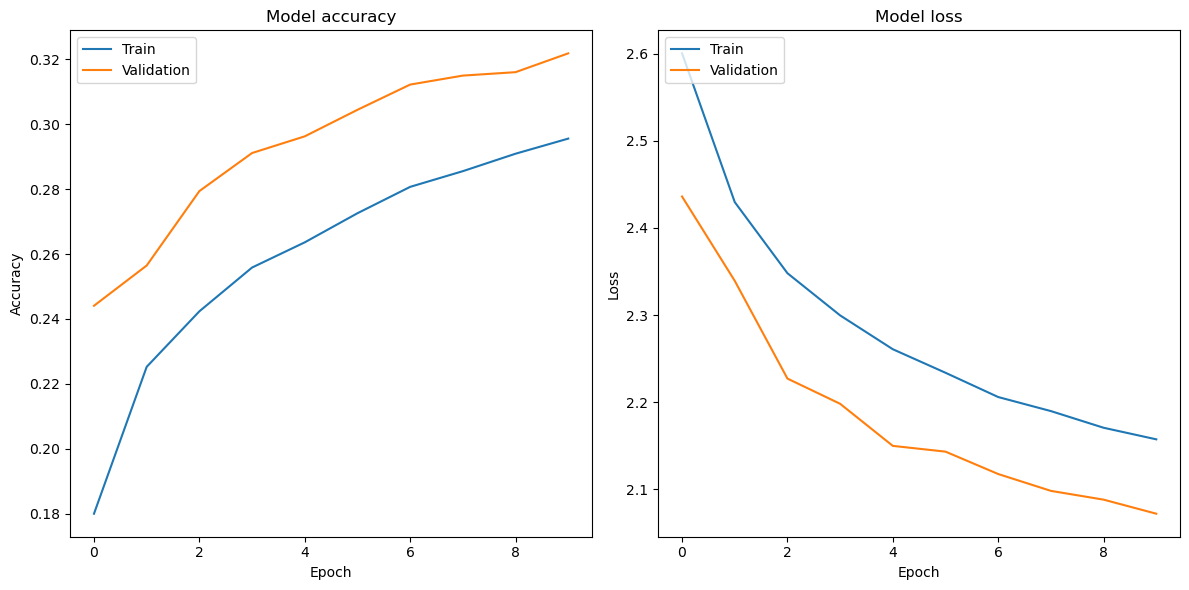

In [23]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()


# Generate confusion matrix, classification report  

238/238 [==============================] - 75s 316ms/step


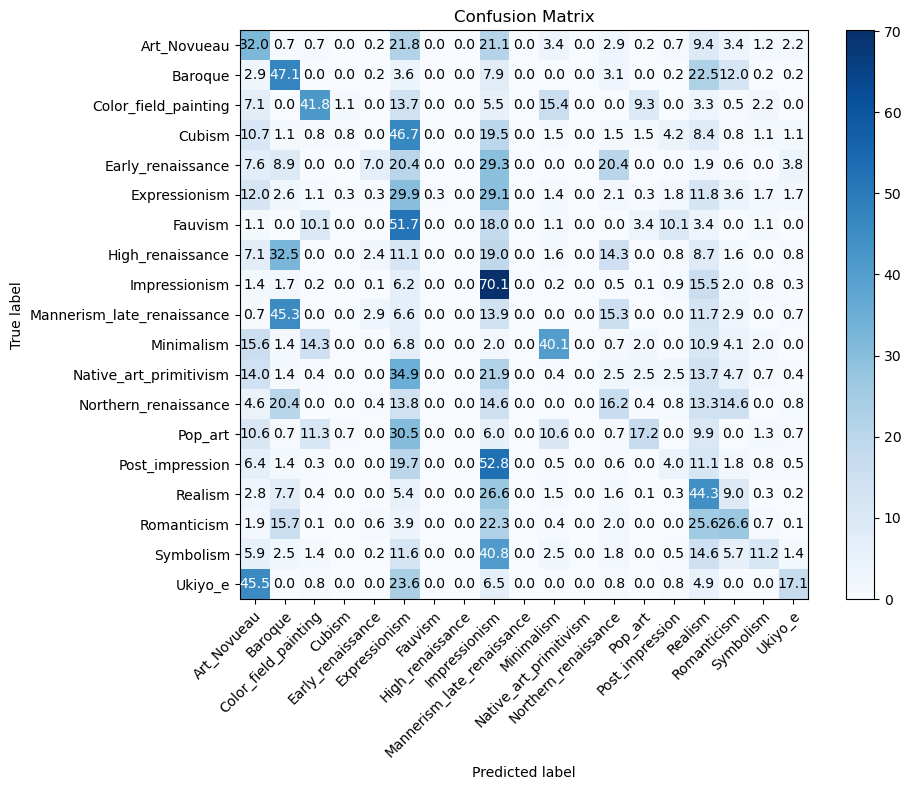

                            precision    recall  f1-score   support

               Art_Novueau       0.23      0.32      0.27       413
                   Baroque       0.31      0.47      0.37       418
      Color_field_painting       0.50      0.42      0.46       182
                    Cubism       0.29      0.01      0.01       261
         Early_renaissance       0.38      0.07      0.12       157
             Expressionism       0.18      0.30      0.22       659
                   Fauvism       0.00      0.00      0.00        89
          High_renaissance       0.00      0.00      0.00       126
             Impressionism       0.37      0.70      0.49      1314
Mannerism_late_renaissance       0.00      0.00      0.00       137
                Minimalism       0.35      0.40      0.37       147
    Native_art_primitivism       0.00      0.00      0.00       278
      Northern_renaissance       0.18      0.16      0.17       240
                   Pop_art       0.39      0.17

C:\Users\PRANAV\.conda\envs\tf_05\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\PRANAV\.conda\envs\tf_05\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\PRANAV\.conda\envs\tf_05\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [24]:
class_names = list(train_generator.class_indices.keys())

# Reset the test generator and make predictions
test_generator.reset()
Y_pred = cnn_model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Normalize confusion matrix to percentages
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Plot confusion matrix
def plot_confusion_matrix(cm, class_names, title='Confusion Matrix', cmap=plt.cm.Blues):
    fig, ax = plt.subplots(figsize=(10, 8))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=class_names, yticklabels=class_names,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.1f'  # Format as percentage with one decimal place
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

# Plot normalized confusion matrix
plot_confusion_matrix(cm_percentage, class_names)
plt.show()

# Print classification report for further evaluation
print(classification_report(y_true, y_pred, target_names=class_names))
